# Querying datasets

In [2]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob
import symphony_data as sd
import tqdm

import sys
sys.path.append('../dj_modules/')
import dj_metadata as djm
import dj_populate as djp

import pandas as pd
sys.path.append('../data_modules/')
import spikeoutputs as so
import spikeplots as sp

[2025-01-07 16:27:52,646][INFO]: Connecting root@127.0.0.1:3306
[2025-01-07 16:27:52,932][INFO]: Connected root@127.0.0.1:3306


In [3]:
dj.config['database.host'] = '127.0.0.1'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'simple'
dj.conn()

DataJoint connection (connected) root@127.0.0.1:3306

In [4]:
ls_protocols = djm.search_protocol('NaturalImage')
print(ls_protocols)

['manookinlab.protocols.NaturalImageFlashNoNoise', 'manookinlab.protocols.NaturalImageFlashPlusNoise']


In [5]:
df_meta = djm.meta_from_protocol(ls_protocols)
df_meta = df_meta.reset_index()
df_meta['dataset'] = df_meta['date_id'] + '_' + df_meta['chunk_id']
df_meta.head()

,date_id,protocol_id,group_idx,data_file,block_idx,chunk_id,frame_times,n_epochs,group_label,source_label,dataset
0,20220712C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data004,0,chunk1,"[[1, 19, 32, 53, 65, 86, 99, 119, 132, 152, 16...",6,natural image flash,,20220712C_chunk1
1,20220712C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data005,1,chunk1,[],7,natural image flash,,20220712C_chunk1
2,20220712C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data006,2,chunk1,[],170,natural image flash,,20220712C_chunk1
3,20220712C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data007,3,chunk1,[],189,natural image flash,,20220712C_chunk1
4,20220712C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data008,4,chunk1,[],200,natural image flash,,20220712C_chunk1


## NaturalImageFlashPlusNoise

In [6]:
df_meta1 = df_meta[df_meta['protocol_id']=='manookinlab.protocols.NaturalImageFlashPlusNoise']
df_meta2 = df_meta[df_meta['protocol_id']=='manookinlab.protocols.NaturalImageFlashNoNoise']

Populate columns with number of unique epoch level stimulus parameters: `imagePatchIndex`, `currentPatchLocation`, `currentNoiseContrast`

In [7]:
ls_param_labels = ['imagePatchIndex','currentNoiseContrast', 'noPatches'] # 'currentPatchLocation', 
d_all_count = {'dataset': []} 
for str_k in ls_param_labels:
    d_all_count['n_'+str_k] = []

for str_dataset in tqdm.tqdm(df_meta1['dataset'].unique()):
    df_dataset = df_meta1[df_meta1['dataset']==str_dataset]
    date_id = df_dataset.iloc[0]['date_id']
    md = sd.Metadata(date_id)

    d_dataset_params = {}
    for str_k in ls_param_labels:
        d_dataset_params[str_k] = np.array([])
    for i_row in range(df_dataset.shape[0]):
        protocol_id = df_dataset.iloc[i_row]['protocol_id']
        data_file = df_dataset.iloc[i_row]['data_file']

        d_p = md.search_data_file(protocol_id, data_file)
        d_params, _ = md.get_stimulus_parameters(d_p, ls_param_labels)
        for str_k in ls_param_labels:
            np_k = np.array(d_params[str_k])
            d_dataset_params[str_k] = np.concatenate((d_dataset_params[str_k], np_k))

    for str_k in ls_param_labels:
        n_unique = len(np.unique(d_dataset_params[str_k], axis=0))
        d_all_count['n_'+str_k].append(n_unique)
    d_all_count['dataset'].append(str_dataset)

100%|██████████| 33/33 [00:53<00:00,  1.62s/it]


In [8]:
df_count1 = pd.DataFrame(d_all_count)
df_count1

,dataset,n_imagePatchIndex,n_currentNoiseContrast,n_noPatches
0,20220712C_chunk1,1,0,1
1,20220712C_chunk3,1,0,1
2,20220818C_chunk1,5,0,1
3,20220818C_chunk2,5,0,1
4,20220818C_chunk3,5,0,1
5,20220823C_chunk2,5,0,1
6,20220823C_chunk4,5,0,1
7,20220823C_chunk5,5,0,1
8,20220823C_chunk6,5,0,1
9,20220829C_chunk3,5,0,1


In [9]:
df_meta1 = df_meta1.merge(df_count1, on=['dataset'], how='left')
df_meta1.head()

,date_id,protocol_id,group_idx,data_file,block_idx,chunk_id,frame_times,n_epochs,group_label,source_label,dataset,n_imagePatchIndex,n_currentNoiseContrast,n_noPatches
0,20220712C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data004,0,chunk1,"[[1, 19, 32, 53, 65, 86, 99, 119, 132, 152, 16...",6,natural image flash,,20220712C_chunk1,1,0,1
1,20220712C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data005,1,chunk1,[],7,natural image flash,,20220712C_chunk1,1,0,1
2,20220712C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data006,2,chunk1,[],170,natural image flash,,20220712C_chunk1,1,0,1
3,20220712C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data007,3,chunk1,[],189,natural image flash,,20220712C_chunk1,1,0,1
4,20220712C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data008,4,chunk1,[],200,natural image flash,,20220712C_chunk1,1,0,1


In [10]:
df_meta1['n_imagePatchIndex'].value_counts()

n_imagePatchIndex
5     57
22    49
1      8
Name: count, dtype: int64

## Plot mosaics for datasets with 22 image patches

In [11]:
df_query = df_meta1[df_meta1['n_imagePatchIndex']==22]

In [12]:
import importlib
importlib.reload(djm)
df_ct = djm.celltyping_from_meta(df_query, verbose=True)

no cell typing for 20230214C chunk3
no cell typing for 20230530C chunk4
no cell typing for 20230530C chunk3
no cell typing for 20230725C chunk1


In [13]:
df_ct

num_cells  \
date_id   protocol_id                     group_idx noise_data_file block_idx chunk_id noise_data_files algorithm b_typing_file_exists typing_file                                                     
20230111C manookinlab.protocols.FastNoise 0         data019         0         chunk1   data019          kilosort2 1                    /Volumes/data-1/analysis/20230111C/chunk1/kilos...       1115   
                                                                                                                                       /Volumes/data-1/analysis/20230111C/chunk1/kilos...       1115   
                                          1         data045         1         chunk3   data045          kilosort2 1                    /Volumes/data-1/analysis/20230111C/chunk3/kilos...       1058   
                                                                                                                                       /Volumes/data-1/analysis/20230111C/chunk3/kilos...        422   
20230228C manookinlab.protocols.FastNoise 0         data045         2         chunk3   data045          kilosort2 1                    /Volumes/data-1/analysis/20230228C/chunk3/kilos...        991   
20230516C manookinlab.protocols.FastNoise 0         data019         0         chunk4   data019          kilosort2 1                    /Volumes/data-1/analysis/20230516C/chunk4/kilos...        890   
                                                                                                                                       /Volumes/data-1/analysis/20230516C/chunk4/kilos...        890   
20230530C manookinlab.protocols.FastNoise 1         data013         0         chunk2   data013          kilosort2 1                    /Volumes/data-1/analysis/20230530C/chunk2/kilos...        935   
20230725C manookinlab.protocols.FastNoise 0         data018         1         chunk3   data018_data019  kilosort2 1                    /Volumes/data-1/analysis/20230725C/chunk3/kilos...        516   
                                          1         data013         1         chunk2   data013_data014  kilosort2 1                    /Volumes/data-1/analysis/20230725C/chunk2/kilos...        660   

                                                                                                                                                                                           num_goodcells  \
date_id   protocol_id                     group_idx noise_data_file block_idx chunk_id noise_data_files algorithm b_typing_file_exists typing_file                                                         
20230111C manookinlab.protocols.FastNoise 0         data019         0         chunk1   data019          kilosort2 1                    /Volumes/data-1/analysis/20230111C/chunk1/kilos...           1115   
                                                                                                                                       /Volumes/data-1/analysis/20230111C/chunk1/kilos...           1115   
                                          1         data045         1         chunk3   data045          kilosort2 1                    /Volumes/data-1/analysis/20230111C/chunk3/kilos...           1058   
                                                                                                                                       /Volumes/data-1/analysis/20230111C/chunk3/kilos...            422   
20230228C manookinlab.protocols.FastNoise 0         data045         2         chunk3   data045          kilosort2 1                    /Volumes/data-1/analysis/20230228C/chunk3/kilos...            991   
20230516C manookinlab.protocols.FastNoise 0         data019         0         chunk4   data019          kilosort2 1                    /Volumes/data-1/analysis/20230516C/chunk4/kilos...            890   
                                                                                                                                       /Volumes/data-1/ana

In [14]:
def create_data_objs(df_ct, algo='kilosort2'):
    # Move multiindex to columns
    df_ct = df_ct.reset_index()

    # Create SpikeOutputs objects for each date-chunk pair with a valid typing file.
    d_data_objs = {}
    
    # Iterate through all date_id and chunk_id in df_ct
    df_ct = df_ct[df_ct['algorithm']==algo]

    dates = df_ct['date_id'].unique()
    for date_id in dates:
        chunks = df_ct[df_ct['date_id']==date_id]['chunk_id'].unique()

        for chunk_id in chunks:
            typing_files = df_ct[(df_ct['date_id']==date_id) & (df_ct['chunk_id']==chunk_id)]['typing_file'].unique()

            for idx_t, typing_file in enumerate(typing_files):
                # Get sum of num_on_p etc for each typing file
                mask = (df_ct['date_id']==date_id) & (df_ct['chunk_id']==chunk_id) & (df_ct['typing_file']==typing_file)
                n_cells = df_ct[mask].loc[:, 'num_on_p':].values.sum()
                if n_cells==0:
                    print(f"ERROR: {typing_file} has no cell types corresponding to defined labels")
                else:
                    
                    d_paths =  {
                    "str_experiment": date_id,
                    
                    "dataset_name": algo,
                    "str_algo": algo,
                    # "str_chunk": chunk_id,
                    "str_classification": typing_file,
                    "str_protocol": "noise",
                    "paramsfile": f'/Volumes/data-1/analysis/{date_id}/{chunk_id}/{algo}/{algo}.params',
                    }

                    data = so.SpikeOutputs(**d_paths)
                    data.load_sta_from_params()
                    
                    str_key = f'{date_id}_{chunk_id}_{idx_t}'
                    d_data_objs[str_key] = data
    return d_data_objs
d_data_objs = create_data_objs(df_ct)

Loading STA from /Volumes/data-1/analysis/20230111C/chunk1/kilosort2/kilosort2.params...
Loaded STA for 1170 cells.
Loading STA from /Volumes/data-1/analysis/20230111C/chunk1/kilosort2/kilosort2.params...
Loaded STA for 1170 cells.
Loading STA from /Volumes/data-1/analysis/20230111C/chunk3/kilosort2/kilosort2.params...


KeyboardInterrupt: 

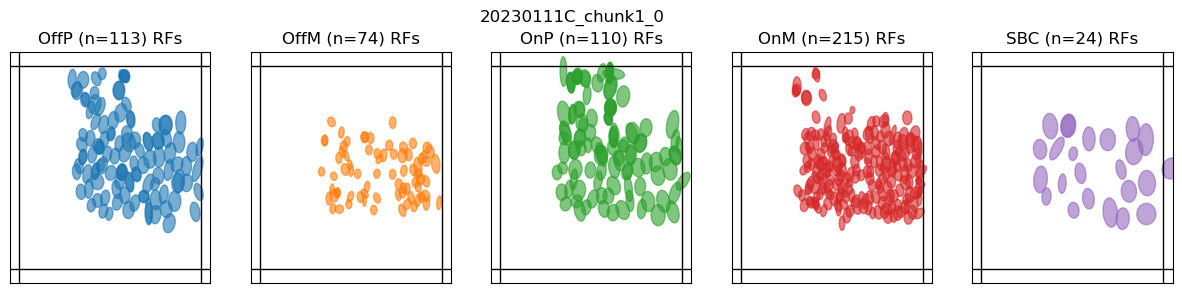

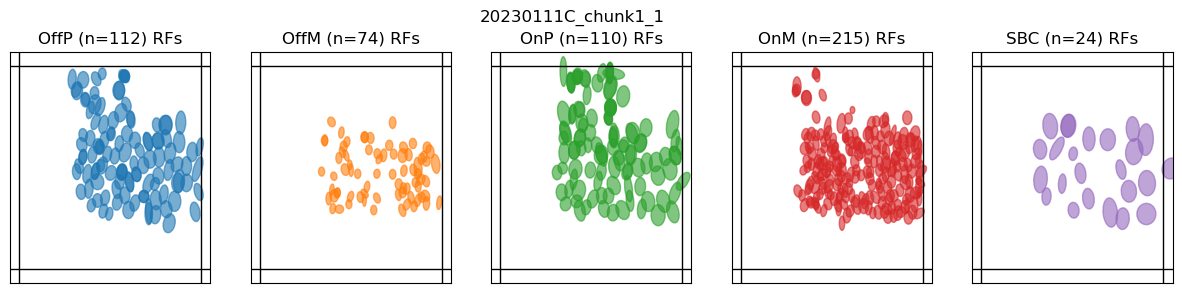

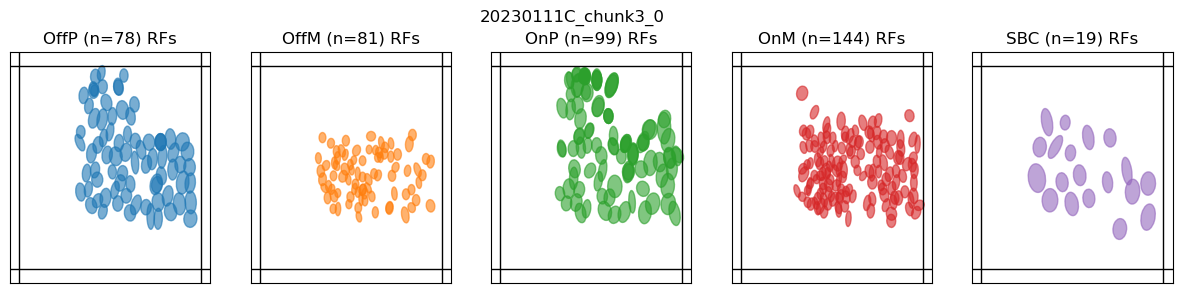

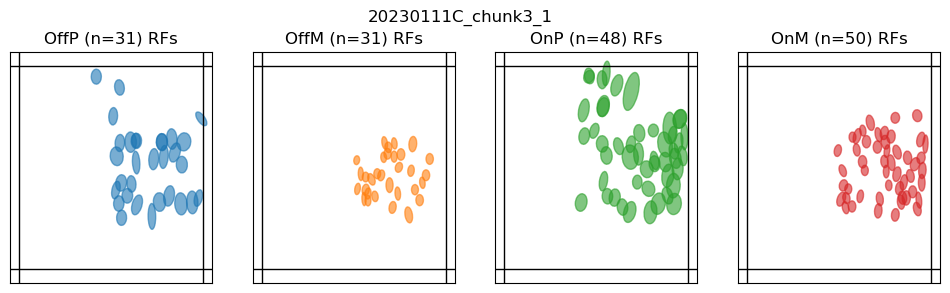

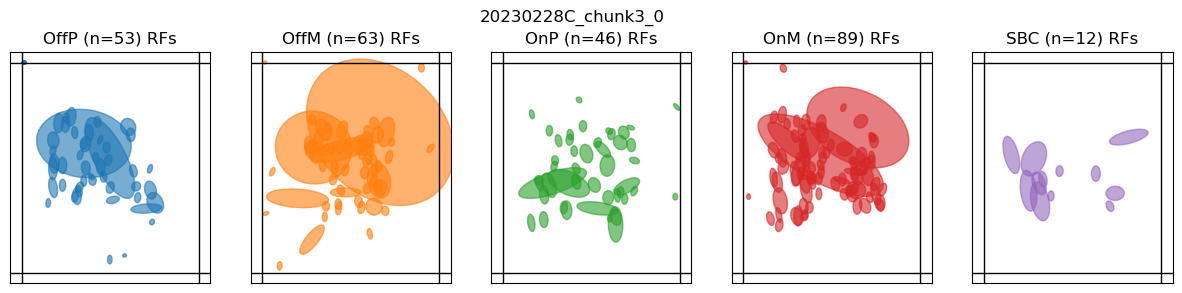

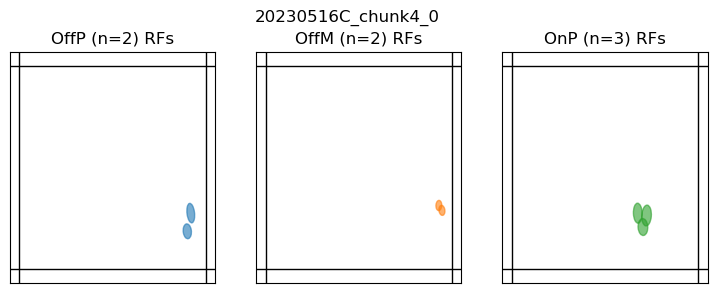

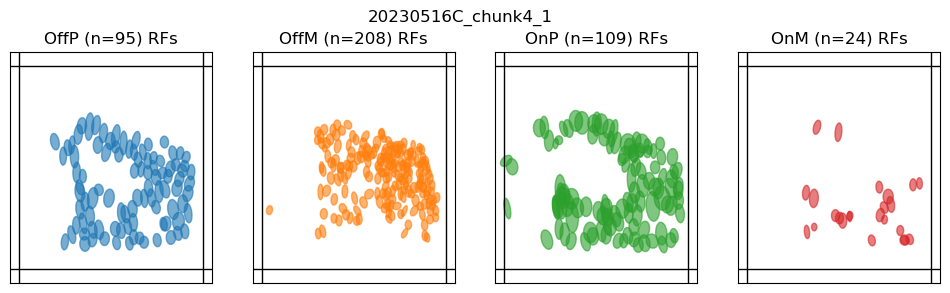

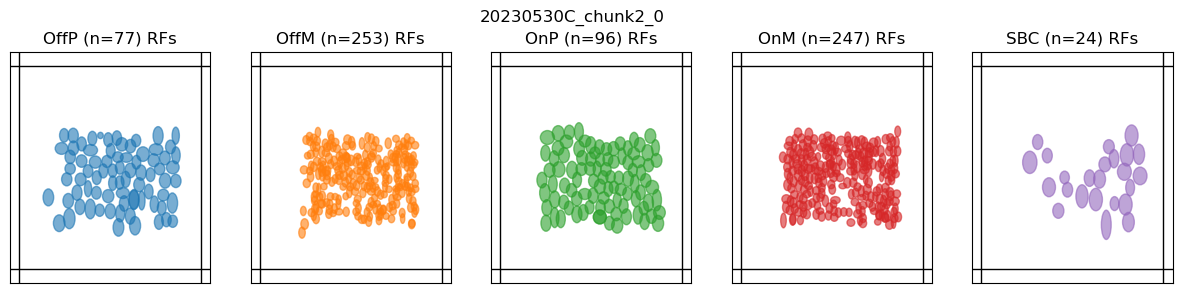

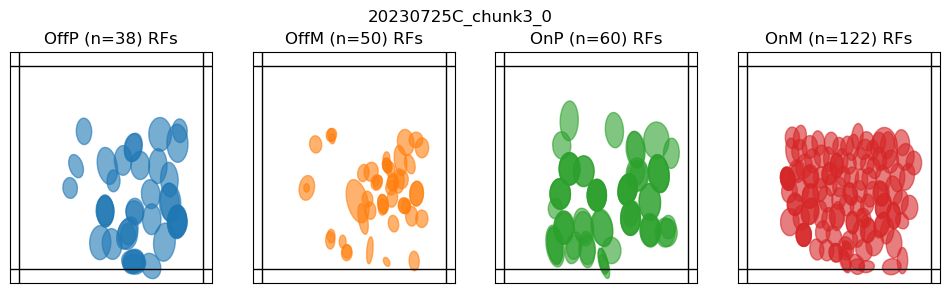

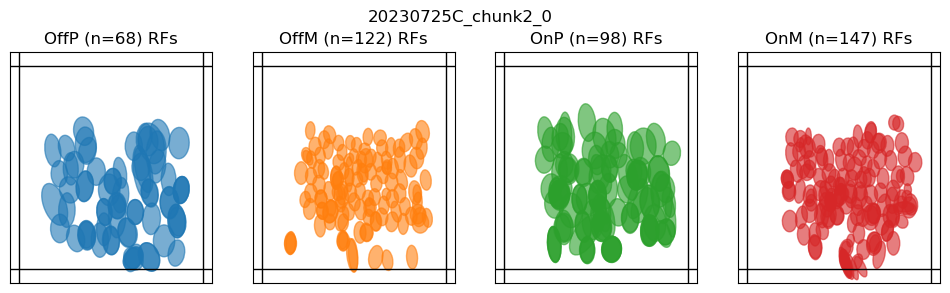

In [77]:
importlib.reload(sp)
for str_key, data in d_data_objs.items():
    axs=sp.plot_type_rfs(data, b_zoom=False, sd_mult=0.8)
    plt.suptitle(str_key, y=1.02)

In [17]:
df_meta1[df_meta1['n_imagePatchIndex']==22]

,date_id,protocol_id,group_idx,data_file,block_idx,chunk_id,frame_times,n_epochs,group_label,source_label,dataset,n_imagePatchIndex,n_currentNoiseContrast,n_noPatches
63,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data010,0,chunk1,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 158...",40,Natural Image Flash 4 nd,,20230111C_chunk1,22,1,1
64,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,0,data011,1,chunk1,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",40,Natural Image Flash 4 nd,,20230111C_chunk1,22,1,1
65,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,1,data041,0,chunk3,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",100,Natural image flash + noise 2 nd,,20230111C_chunk3,22,2,2
66,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,1,data042,1,chunk3,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",100,Natural image flash + noise 2 nd,,20230111C_chunk3,22,2,2
67,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,2,data036,0,chunk3,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 158...",100,Natural image flash + noise 3 nd,,20230111C_chunk3,22,2,2
68,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,2,data037,1,chunk3,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",80,Natural image flash + noise 3 nd,,20230111C_chunk3,22,2,2
69,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,2,data038,2,chunk3,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",100,Natural image flash + noise 3 nd,,20230111C_chunk3,22,2,2
70,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,3,data016,0,chunk1,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",40,Natural image flash 0 nd,,20230111C_chunk1,22,1,1
71,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,3,data017,1,chunk1,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 159...",40,Natural image flash 0 nd,,20230111C_chunk1,22,1,1
72,20230111C,manookinlab.protocols.NaturalImageFlashPlusNoise,4,data031,0,chunk3,"[[1, 6, 26, 39, 59, 72, 92, 105, 125, 139, 158...",40,Natural image flash 1 nd,,20230111C_chunk3,22,2,2


In [15]:
df_meta1[(df_meta1['date_id']=='20230530C')&(df_meta1['chunk_id']=='chunk2')]

,date_id,protocol_id,group_idx,data_file,block_idx,chunk_id,frame_times,n_epochs,group_label,source_label,dataset,n_imagePatchIndex,n_currentNoiseContrast,n_noPatches
104,20230530C,manookinlab.protocols.NaturalImageFlashPlusNoise,4,data017,0,chunk2,"[[0.0, 16.0, 33.0, 49.0, 66.0, 83.0, 99.0, 116...",40,Natural Image Flash No Noise img2,20230530Cm1,20230530C_chunk2,22,1,1
105,20230530C,manookinlab.protocols.NaturalImageFlashPlusNoise,5,data016,0,chunk2,[],40,Natural Image Flash No Noise img1,20230530Cm1,20230530C_chunk2,22,1,1
106,20230530C,manookinlab.protocols.NaturalImageFlashPlusNoise,6,data020,0,chunk2,"[[0.0, 16.0, 33.0, 50.0, 66.0, 83.0, 99.0, 116...",40,Natural Image Flash No Noise img1 ndf1,20230530Cm1,20230530C_chunk2,22,1,1
107,20230530C,manookinlab.protocols.NaturalImageFlashPlusNoise,7,data021,0,chunk2,"[[0.0, 16.0, 33.0, 50.0, 66.0, 83.0, 99.0, 116...",40,Natural Image Flash No Noise img2,20230530Cm1,20230530C_chunk2,22,1,1
